## **garbage classification with computer vision**

le bute de ce notebook est de faire une classification de déchets selon 5 classe d'objet (papier,verre,metal,plastique et carton) en utilisant un apprentissage supervisé.
les etapes de la realisation de ce projet sont:



1.   partition de la dataset
2.   augmentation de données
3.   creation et apprentissage du model















In [ ]:
import os,shutil

### 1-Partition de la dataset:
pour effectuer cette taches nous utiliserons un jeu de données contenant 400 images des 5 classes de déchets sité précédement (2000 image au totale) ,chacune des classes recevera un partition 80/20 de tel sorte que 80% de la dataset sera pour l'entrainement du model et 20% ou les testes du model
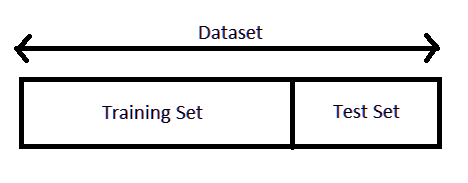


ce qui nous donne a la fin 1500 images de train et 500 de teste

In [ ]:
def split():
  x=os.listdir("./drive/MyDrive/mlh cv/Garbage")
  for i in x:
    y=os.listdir("./drive/MyDrive/mlh cv/Garbage/"+i)
    for j in range(0,400):
      print(y[j])
      if(j<300):
        
        shutil.copy("./drive/MyDrive/mlh cv/Garbage/"+i+'/'+y[j],"./drive/MyDrive/mlh cv/dataset/train/"+y[j])
      else:
        shutil.copy("./drive/MyDrive/mlh cv/Garbage/"+i+'/'+y[j],"./drive/MyDrive/mlh cv/dataset/test/"+y[j])

split()

### 2-Augmentation du jeu de données:

Après la partition du jeu de données, nous nous trouvons avec 1500 images pour entrainer notre modèle, néanmoins, ce nombre reste très bas pour un modèle de deep learning, c'est pour ça que nous devons passer par une augmentation de données qui consiste à, apartir de chaque image, récupérer de nouvelles en faisant des opérations telles que la rotation à 90,180, 270, inversions de couleur...

nous passons alors de 1500 images a 12000 images
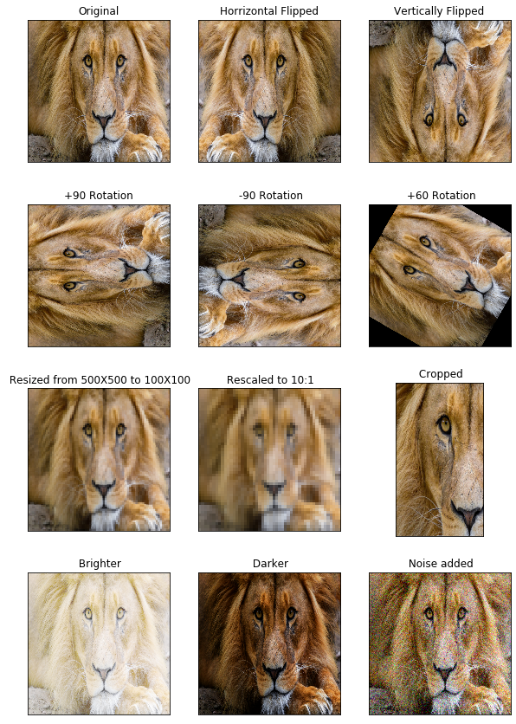

In [ ]:
import cv2
def flip():
    images="./drive/MyDrive/mlh cv/dataset/train"

    x=os.listdir(images)
    cpt=0
    for i in x:
        print(cpt)
        cpt=cpt+1
        img=cv2.imread(images+"/"+i,cv2.IMREAD_UNCHANGED)
        rotate=cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
        cv2.imwrite(images+"/flip90"+i,rotate)
        rotate = cv2.rotate(img, cv2.ROTATE_180)
        cv2.imwrite(images + "/flip180" + i, rotate)
        rotate = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        cv2.imwrite(images + "/flip270" + i, rotate)
flip()

In [ ]:
def reversecolor():
  images="./drive/MyDrive/mlh cv/dataset/train"
  x=os.listdir(images)
  cpt=0
  for i in x:
      print(cpt)
      img=cv2.imread(images+"/"+i,cv2.IMREAD_UNCHANGED)
      img=(255-img)
      cv2.imwrite(images+"/rev"+i,img)
      cpt=cpt+1
reversecolor()

### 3-creation et apprentissage du model:

apres l'execution des étapes 2 et 3, nous  nous focalisons sur la formation et la gestion de notre model

nous commencerons par la definition de la class custom_generator qui s'occupe de la gestion de notre jeu de donnée ,puis nous definirons notre model d'apprentissage qui est un CNN



In [ ]:
import os
import cv2 as cv
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Dense,Flatten
from keras.applications import VGG16
import keras.backend as k


In [ ]:
class Custom_Generator(keras.utils.Sequence):
    def __init__(self, rgb_path, batch_size):
        self.batch_size = batch_size
        self.length = len(os.listdir(rgb_path))

        self.rgb_path = rgb_path

        self.indexes = np.arange(self.length)
        self.on_epoch_end()

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(self.length / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        x = np.empty((self.batch_size, 224, 224, 3))
        y = np.empty((self.batch_size, 5))

        cpt = 0

        for i in indexes:
            rgb_input = cv.imread(self.rgb_path + "/" + os.listdir(self.rgb_path)[i])


            rgb_input = cv.resize(rgb_input, (224, 224))
            x[cpt,] = rgb_input

            if("cardboard" in os.listdir(self.rgb_path)[i]):
                y[cpt,] = np.array([1,0,0,0,0])
            if ("glass" in os.listdir(self.rgb_path)[i]):
                y[cpt,] = np.array([0, 1, 0, 0, 0])
            if ("metal" in os.listdir(self.rgb_path)[i]):
                y[cpt,] = np.array([0, 0, 1, 0, 0])
            if ("paper" in os.listdir(self.rgb_path)[i]):
                y[cpt,] = np.array([0, 0, 0, 1, 0])
            if ("plastic" in os.listdir(self.rgb_path)[i]):
                y[cpt,] = np.array([0, 0, 0, 0, 1])




            cpt += 1
        return x, y


la fonction createmodel retourne un model d'apprentissage qui est basé sur model vgg16

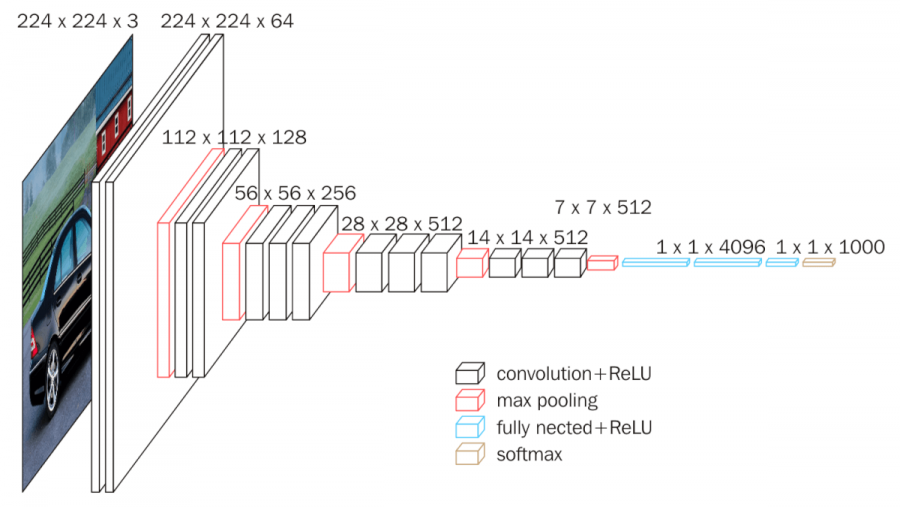

In [ ]:
def createmodel():
    vgg=VGG16(weights="imagenet",include_top=False,input_shape=(224,224,3))
    for i in range(len(vgg.layers)):
        if i < 15:
            vgg.layers[i].trainable=False
    z=vgg.output
    z=Flatten()(z)
    z=Dense(units=4096,activation="relu")(z)
    z = Dense(units=4096, activation="relu")(z)
    z = Dense(units=1000, activation="relu")(z)
    z = Dense(units=5, activation="softmax")(z)
    print(z)
    modeltoreturn =Model(inputs=vgg.input,outputs=z)
    modeltoreturn.compile(keras.optimizers.Adam(lr=1e-3),loss=keras.losses.CategoricalCrossentropy(),metrics=[keras.metrics.binary_accuracy])
    return modeltoreturn

In [ ]:
LR_Scheduler_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='min',min_delta=0.0001, cooldown=1, min_lr=0)

In [ ]:
save_per_epoch = keras.callbacks.ModelCheckpoint(
    filepath="./drive/MyDrive/model_weights_epoch-{epoch:02d}-" + str(int(time.time())) + ".h5", verbose=1, monitor="val_loss",
    mode="min")

In [ ]:
print("Start")
model=createmodel()
path="./drive/MyDrive/mlh cv/dataset/train"
path2="./drive/MyDrive/mlh cv/dataset/test"
l=len(os.listdir(path))
l2=len(os.listdir(path2))
hist=model.fit_generator(
    generator=Custom_Generator(path,64),
    steps_per_epoch=int(np.floor((l/64))),
    epochs=5,
    verbose=1,
    validation_data=Custom_Generator(path2,64),
    validation_steps=int(np.floor((l2/64))),
    callbacks=[LR_Scheduler_loss,save_per_epoch]
)
model.save("./drive/MyDrive/mlh.h5")


In [ ]:
model.loadweight("")
x=model.fit("")
